In [2]:
import cartopy
import cmocean
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy import io, interpolate
import pyproj

%matplotlib widget

In [2]:
# Load the play 1 dataframe
df = pd.read_csv('../data/play1_df.csv')
df.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'time', 'latitude', 'longitude', 'hs',
       'wave_direction', 'wave_direction_mathconv', 'drift_speed',
       'drift_direction', 'instrument_type', 'windspd', 'winddir', 'swiftnum',
       'winddir_mathconv', 'wave_period', 'salinity', 'water_temperature',
       'along ice coord', 'cross ice coord', 'ice edge bearing',
       'ice edge origin lon', 'ice edge origin lat', 'along ice drift speed',
       'cross ice drift speed', 'along ice wind speed', 'cross ice wind speed',
       'along ice wind corrected drift speed',
       'cross ice wind corrected drift speed', 'ice concentration'],
      dtype='object')

: 

: 

2022-09-10 00:00:00
129.48148753118673
68.31777104609144


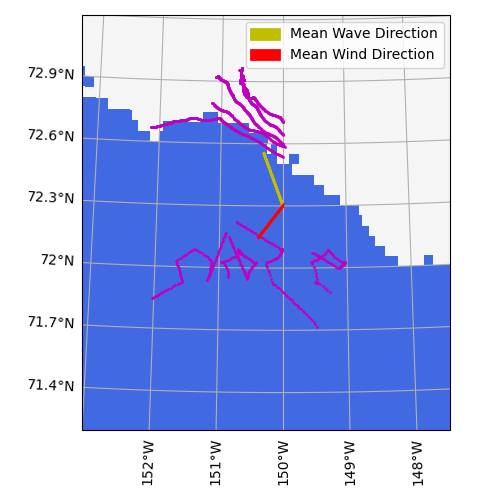

: 

: 

In [33]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

# Load the Gridded Ice Maps
ice_map_data = io.loadmat('../data/L1/nws_2022.mat')
ice_map_lat = ice_map_data['LAT']
ice_map_lon = ice_map_data['LON']
ice_map_conc = ice_map_data['iceconc'] * 10
ice_map_datenum = np.squeeze(ice_map_data['date'])
ice_map_date = [datenum_to_datetime(ice_map_datenum[n].astype(np.float64)) for n in range(ice_map_datenum.size)]

# Find index of closest Ice Map - September 10th 
ind_for_ice_map = 252
print(ice_map_date[ind_for_ice_map])

# Compute Ice Edge Based on 15% Concentration
ice_conc_15percent = np.zeros(ice_map_conc[:,:,ind_for_ice_map].shape)
ice_conc_15percent[ice_map_conc[:,:,ind_for_ice_map] >= 15] = 1

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the mean wave direction
mean_wave_dir = np.mean(df['wave_direction'])
print(mean_wave_dir) # this is in the convention that waves are coming from this direction
ax.arrow(-150, 72.3,
        0.4*np.cos(np.deg2rad(270 - mean_wave_dir)), 
        0.4*np.sin(np.deg2rad(270 - mean_wave_dir)), color='y', 
        transform=cartopy.crs.PlateCarree(), linewidth=2, label='Mean Wave Direction')

# Plot the mean wind direction
mean_wind_dir = np.mean(df['winddir'])
print(mean_wind_dir) # Convention that wind is coming from this direction
ax.arrow(-150, 72.3,
        0.4*np.cos(np.deg2rad(270 - mean_wind_dir)), 
        0.4*np.sin(np.deg2rad(270 - mean_wind_dir)), color='r', 
        transform=cartopy.crs.PlateCarree(), linewidth=2, label='Mean Wind Direction')

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
ax.legend()
plt.tight_layout()

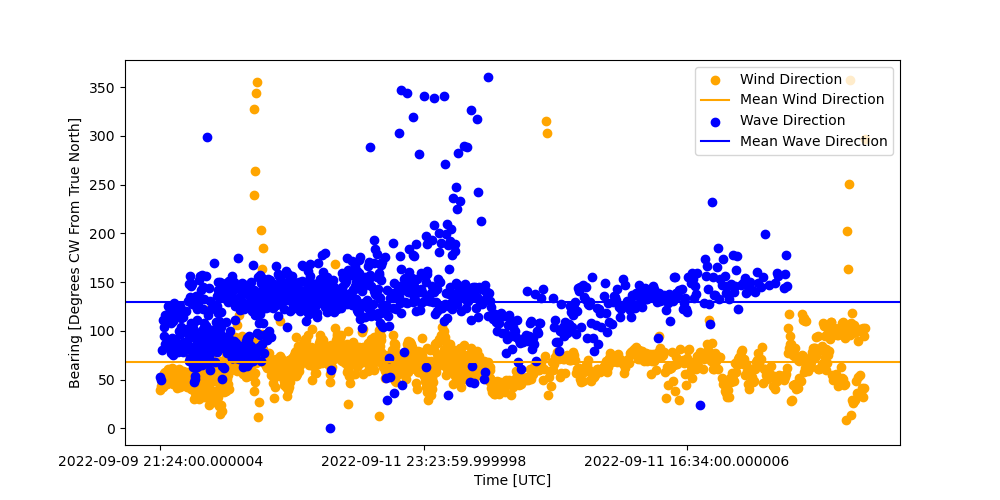

: 

: 

In [31]:
# Plot time series of wind and wave direction
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df['time'], df['winddir'], label='Wind Direction', color='orange')
ax.axhline(np.mean(df['winddir']), label='Mean Wind Direction', color='orange')
ax.scatter(df['time'], df['wave_direction'], label='Wave Direction', color='blue')
ax.axhline(np.mean(df['wave_direction']), label='Mean Wave Direction', color='blue')
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Bearing [Degrees CW From True North]')
ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(3))

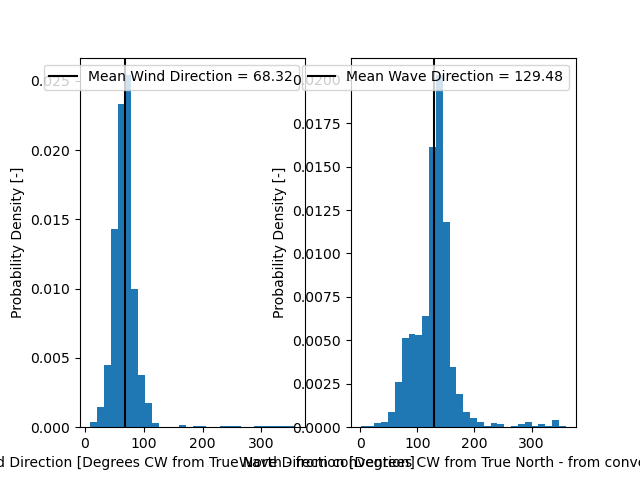

: 

: 

In [30]:
# Histograms of Wind Direction
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.hist(df['winddir'], bins=30, density=True)
ax1.set_ylabel('Probability Density [-]')
ax1.set_xlabel('Wind Direction [Degrees CW from True North - from convention]')
mean_wind_dir = np.mean(df['winddir'])
ax1.axvline(mean_wind_dir, color='k', label=f'Mean Wind Direction = {np.round(mean_wind_dir, 2)}')
ax1.legend()

ax2.hist(df['wave_direction'], bins=30, density=True)
ax2.set_ylabel('Probability Density [-]')
ax2.set_xlabel('Wave Direction [Degrees CW from True North - from convention]')
mean_wave_dir = np.mean(df['wave_direction'])
ax2.axvline(mean_wave_dir, color='k', label=f'Mean Wave Direction = {np.round(mean_wave_dir, 2)}')
ax2.legend()

Text(0, 0.5, 'Cross Ice Coordinate [m]')

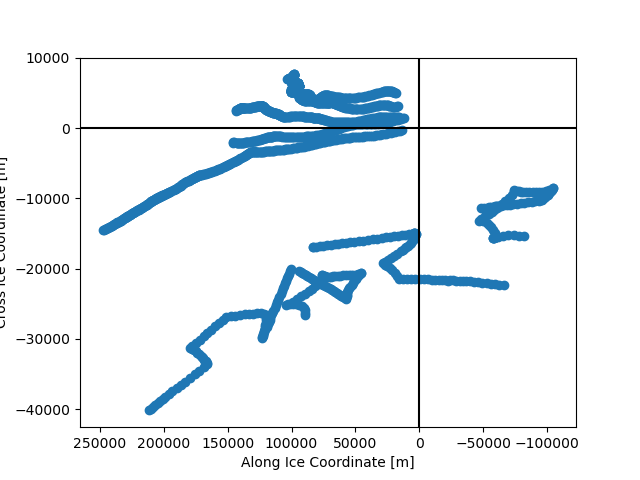

: 

: 

In [5]:
# Plot the locations of SWIFTs in the ice edge coordinate system
fig, ax = plt.subplots()
ax.scatter(df['along ice coord'], df['cross ice coord'])
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.invert_xaxis()
ax.set_xlabel('Along Ice Coordinate [m]')
ax.set_ylabel('Cross Ice Coordinate [m]')

Text(0, 0.5, 'Cross Ice Coordinate [m]')

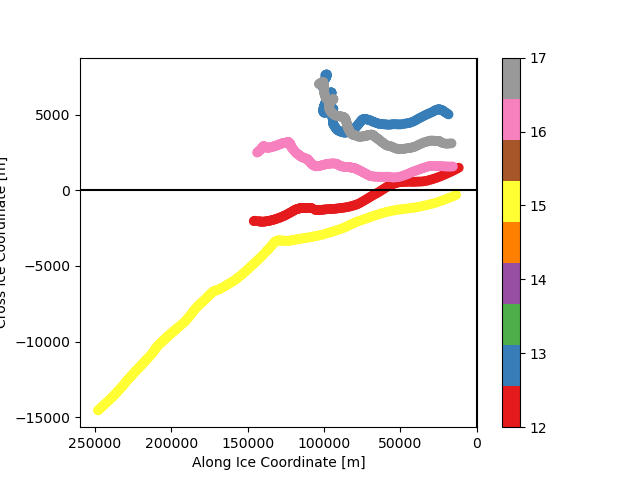

: 

: 

In [6]:
# Plot the locations of SWIFTs in the ice edge coordinate system
fig, ax = plt.subplots()
im = ax.scatter(df['along ice coord'], df['cross ice coord'], c=df['swiftnum'], cmap='Set1')
fig.colorbar(im)
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.invert_xaxis()
ax.set_xlabel('Along Ice Coordinate [m]')
ax.set_ylabel('Cross Ice Coordinate [m]')

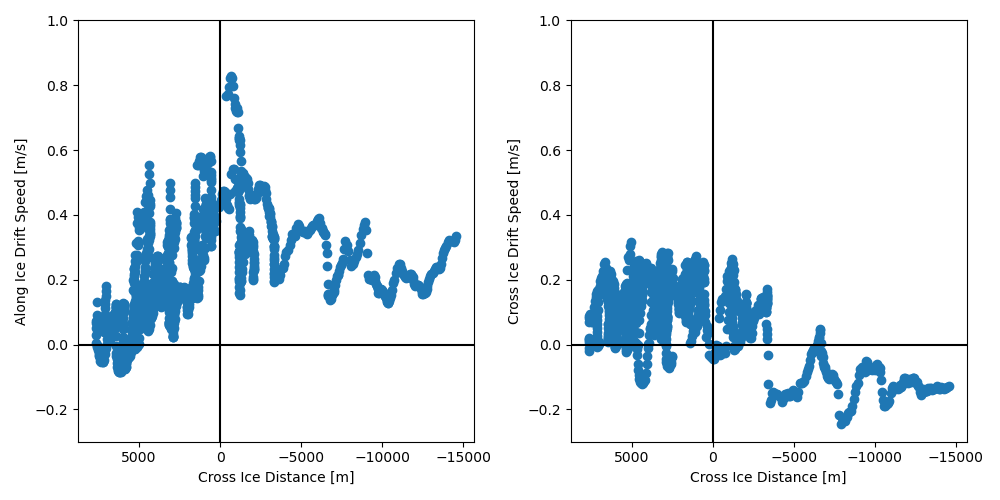

: 

: 

In [7]:
# Plot drift speed in ice edge coordinate system
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.scatter(df['cross ice coord'], df['along ice drift speed'])
ax1.set_xlabel('Cross Ice Distance [m]')
ax1.set_ylabel('Along Ice Drift Speed [m/s]')
ax1.axvline(0, color='k')
ax1.axhline(0, color='k')
ax1.invert_xaxis()
ax1.set_ylim(-0.3, 1)

ax2.scatter(df['cross ice coord'], df['cross ice drift speed'])
ax2.set_xlabel('Cross Ice Distance [m]')
ax2.set_ylabel('Cross Ice Drift Speed [m/s]')
ax2.axvline(0, color='k')
ax2.axhline(0, color='k')
ax2.invert_xaxis()
ax2.set_ylim(-0.3, 1)

plt.tight_layout()

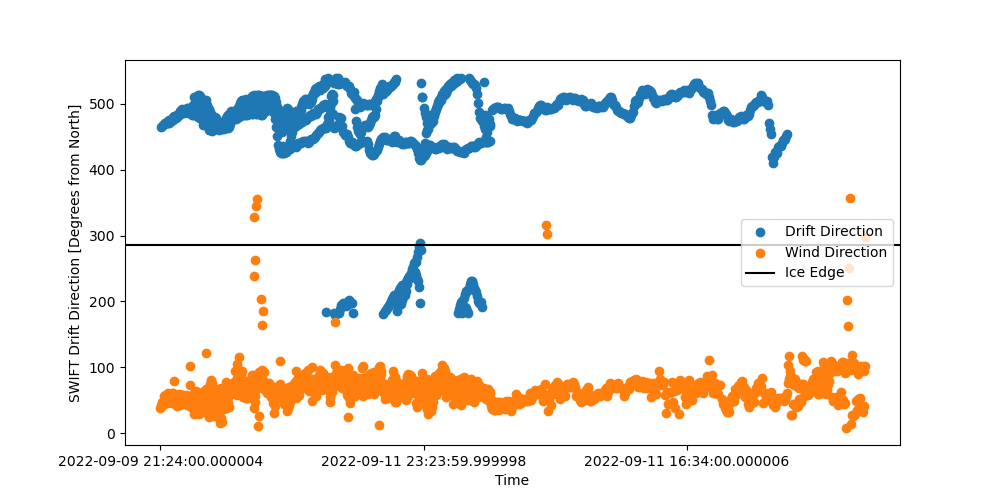

: 

: 

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df['time'], 180 + df['drift_direction'], label='Drift Direction')
ax.scatter(df['time'], df['winddir'], label='Wind Direction')
ax.axhline(285, color='k', label='Ice Edge')
ax.set_xlabel('Time')
ax.set_ylabel('SWIFT Drift Direction [Degrees from North]')
ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(3))

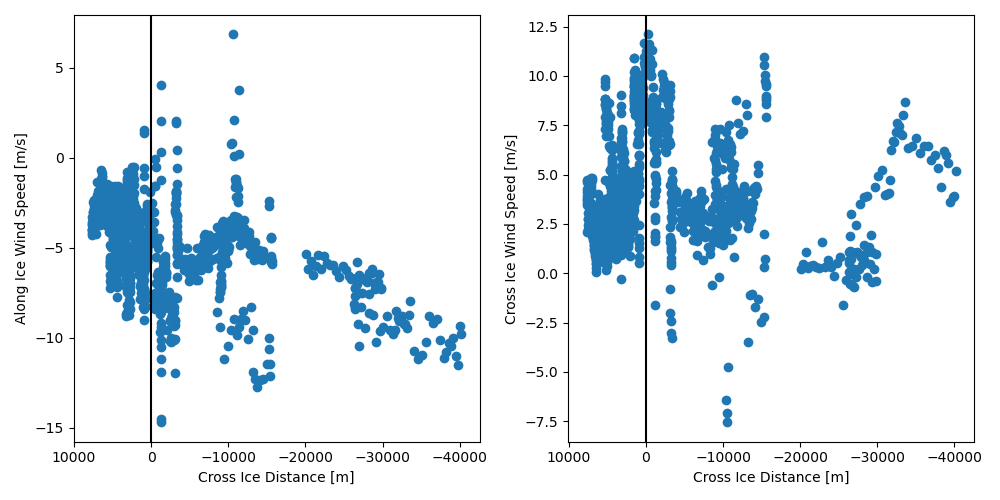

: 

: 

In [9]:
# Plot along and cross ice wind speed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.scatter(df['cross ice coord'], df['along ice wind speed'])
ax1.set_xlabel('Cross Ice Distance [m]')
ax1.set_ylabel('Along Ice Wind Speed [m/s]')
ax1.axvline(0, color='k')
ax1.invert_xaxis()

ax2.scatter(df['cross ice coord'], df['cross ice wind speed'])
ax2.set_xlabel('Cross Ice Distance [m]')
ax2.set_ylabel('Cross Ice Wind Speed [m/s]')
ax2.axvline(0, color='k')
ax2.invert_xaxis()

plt.tight_layout()

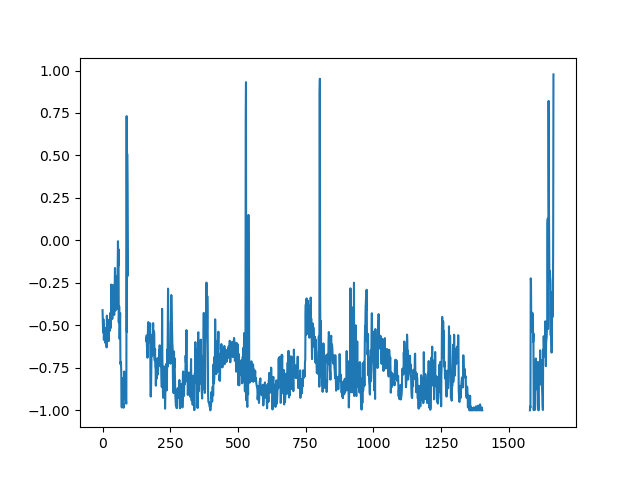

: 

: 

In [10]:
# plot the wind direction and drift direction
fig, ax = plt.subplots()
# ax.plot(np.cos(np.deg2rad(df['drift_direction']-df['ice edge bearing'])))
ax.plot(np.cos(np.deg2rad(df['winddir'] - df['ice edge bearing'])))

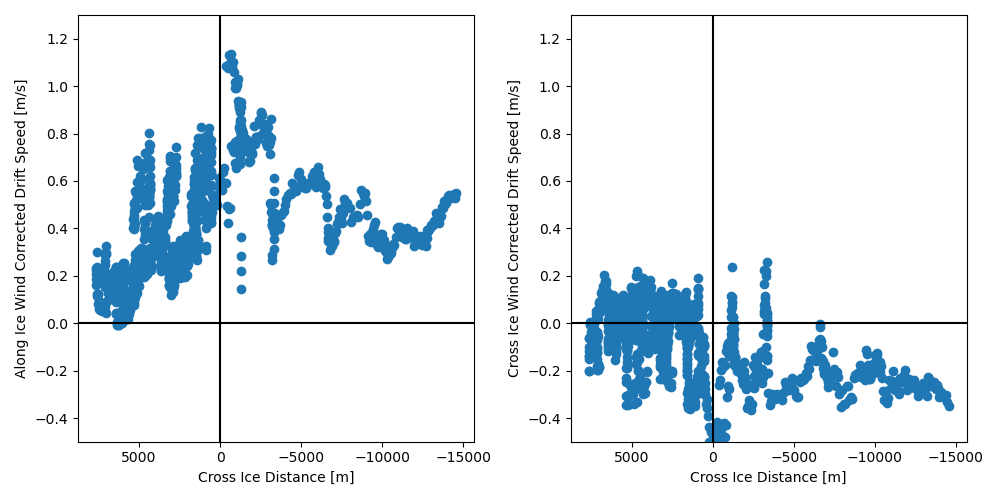

: 

: 

In [11]:
# Plot along and cross ice wind corrected drift speed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.scatter(df['cross ice coord'], df['along ice wind corrected drift speed'])
ax1.set_xlabel('Cross Ice Distance [m]')
ax1.set_ylabel('Along Ice Wind Corrected Drift Speed [m/s]')
ax1.axvline(0, color='k')
ax1.axhline(0, color='k')
ax1.invert_xaxis()
ax1.set_ylim(-0.5, 1.3)

ax2.scatter(df['cross ice coord'], df['cross ice wind corrected drift speed'])
ax2.set_xlabel('Cross Ice Distance [m]')
ax2.set_ylabel('Cross Ice Wind Corrected Drift Speed [m/s]')
ax2.axvline(0, color='k')
ax2.axhline(0, color='k')
ax2.invert_xaxis()
ax2.set_ylim(-0.5, 1.3)

plt.tight_layout()

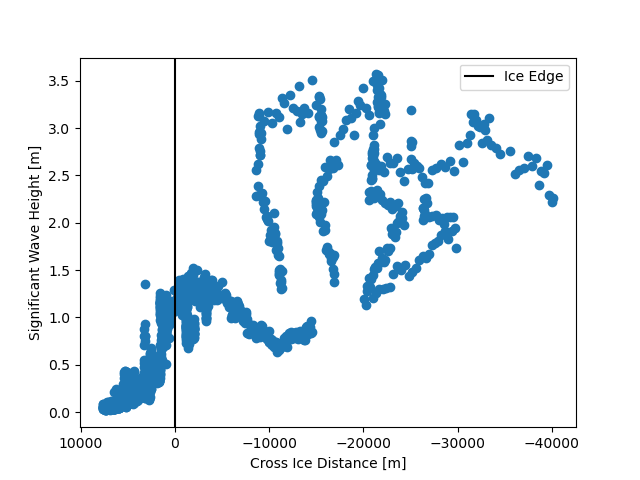

: 

: 

In [12]:
fig, ax = plt.subplots()
ax.scatter(df['cross ice coord'], df['hs'])
ax.invert_xaxis()
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.axvline(0, label='Ice Edge', color='k')
ax.legend()

Text(0, 0.5, 'Cross Ice Coordinate [m]')

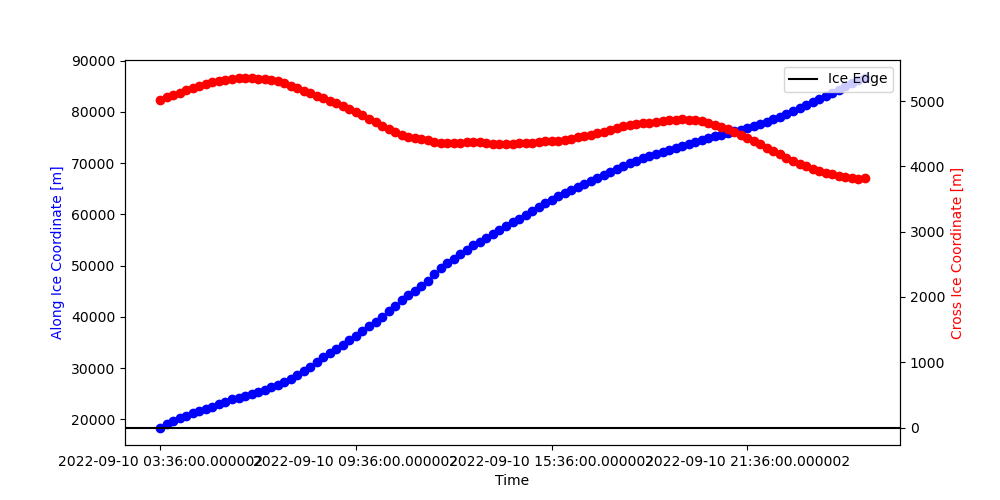

: 

: 

In [13]:
# plot time series of positon of SWIFT 13
swift13_df = df[df['swiftnum'] == 13]
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(swift13_df['time'], swift13_df['along ice coord'], color='b')
ax.set_xlabel('Time')
ax.set_ylabel('Along Ice Coordinate [m]', color='b')
# ax.axvline(datetime(2022, 9, 10, 3, 36, 12))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

ax2 = ax.twinx()
ax2.scatter(swift13_df['time'], swift13_df['cross ice coord'], color='r')
ax2.axhline(0, label='Ice Edge', color='k')
ax2.legend()
ax2.set_ylabel('Cross Ice Coordinate [m]', color='r')

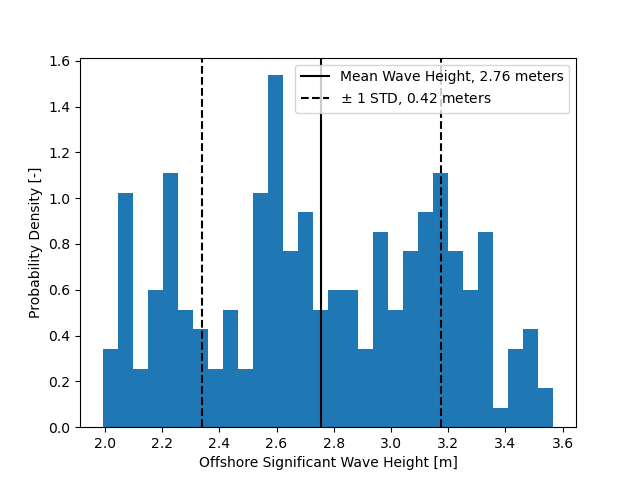

: 

: 

In [26]:
# Compute Average Offshore Wave Height and Standard deviation
Hs_offshore = df[df['cross ice coord'] < -7000]['hs']

fig, ax = plt.subplots()
ax.hist(Hs_offshore, bins=30, density=True)
ax.set_xlabel('Offshore Significant Wave Height [m]')
ax.set_ylabel('Probability Density [-]')
ax.axvline(np.mean(Hs_offshore), color='k', label=f'Mean Wave Height, {np.round(np.mean(Hs_offshore), 2)} meters')
ax.axvline(np.mean(Hs_offshore) + np.std(Hs_offshore), color='k', linestyle='dashed', label=f'$\pm$ 1 STD, {np.round(np.std(Hs_offshore), 2)} meters')
ax.axvline(np.mean(Hs_offshore) - np.std(Hs_offshore), color='k', linestyle='dashed')
ax.legend()

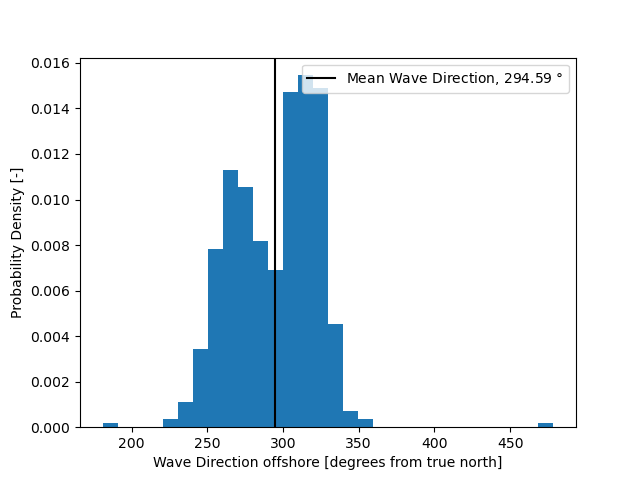

: 

: 

In [32]:
# Compute Average Offshore Wave Height and Standard deviation
wave_dir= df['wave_direction'] + 180

fig, ax = plt.subplots()
ax.hist(wave_dir, bins=30, density=True)
ax.set_xlabel('Wave Direction offshore [degrees from true north]')
ax.set_ylabel('Probability Density [-]')
ax.axvline(np.mean(wave_dir), color='k', label=f'Mean Wave Direction, {np.round(np.mean(wave_dir), 2)} $\degree$')
# ax.axvline(np.mean(Hs_offshore) + np.std(Hs_offshore), color='k', linestyle='dashed', label=f'$\pm$ 1 STD, {np.round(np.std(Hs_offshore), 2)} meters')
# ax.axvline(np.mean(Hs_offshore) - np.std(Hs_offshore), color='k', linestyle='dashed')
ax.legend()